In [1]:
import numpy as np
import matplotlib.pyplot as plt

percentiles=np.load('../../spender/saved_input/percentiles_100000.npy')
ms_real=np.load('../../../sfh_100000.npy')
seds_real=np.load('../../../seds_100000.npy')

index_sh=np.load('../saved_models/index_sh_1e5.npy')

means_sh=np.load('../saved_models/best/means_1e5_m216_full.npy') #predictions
percentiles_sh=percentiles[index_sh] #reals
seds_real_sh=seds_real[index_sh]

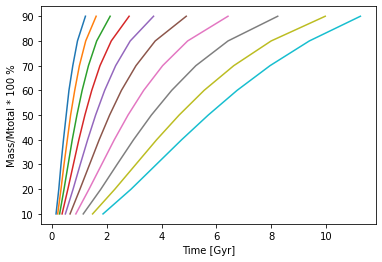

Text(0, 0.5, 'Flux')

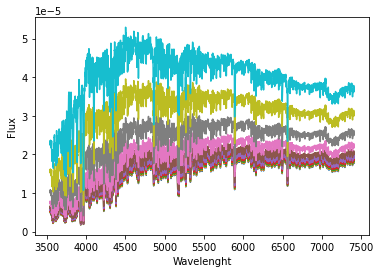

In [38]:
for i in np.arange(0,100000,10000): #really 100.000 examples
    plt.plot(percentiles[i,:],np.arange(10,100,10))
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')

plt.show()

for i in np.arange(0,100000,10000): #really 100.000 examples
    plt.plot(wave,seds_real[i,:])
plt.xlabel('Wavelenght')
plt.ylabel('Flux')

The SFH are the derivative of the curves of growth (with percentiles). Notice our Ys are the percentages, and our Xs the time of each percentil

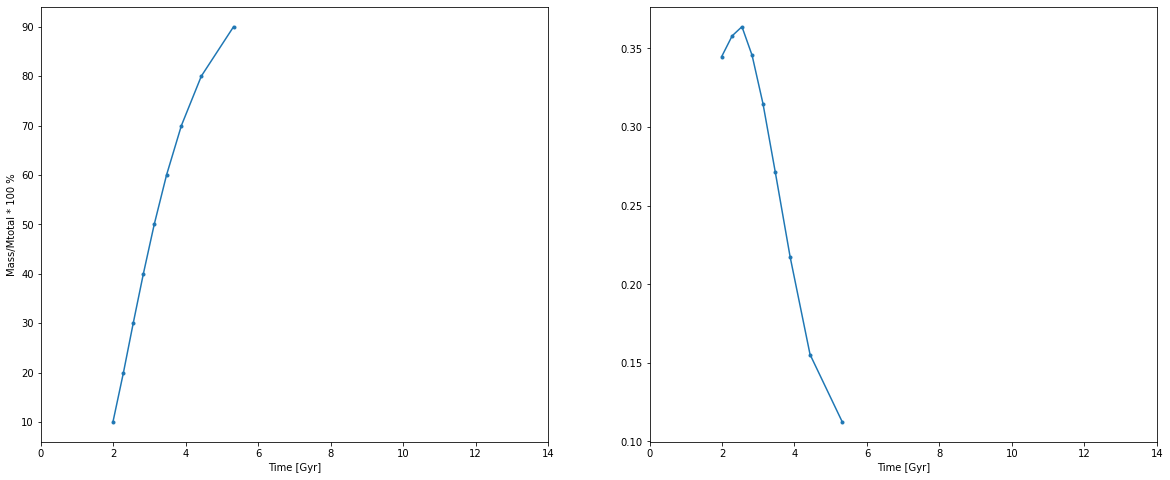

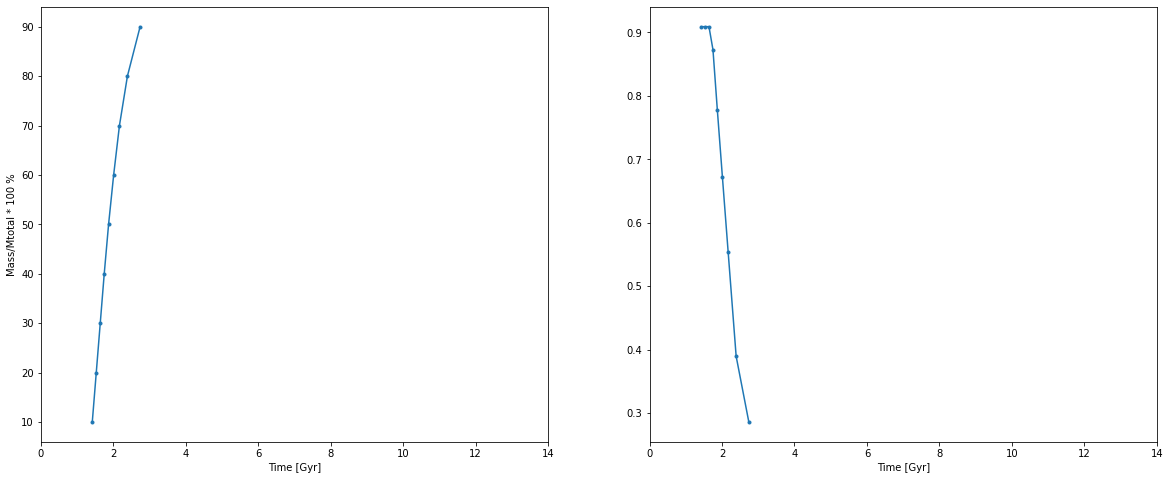

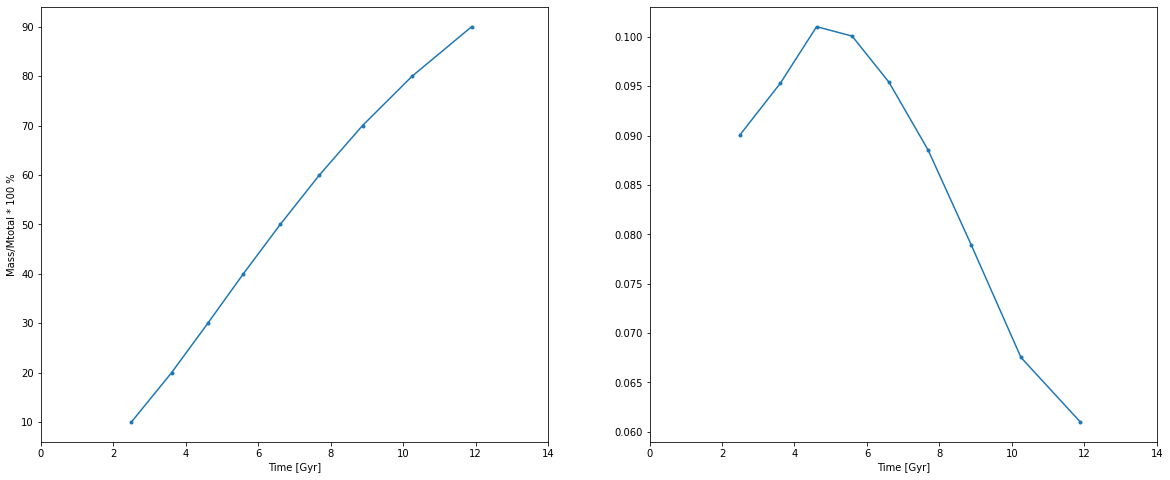

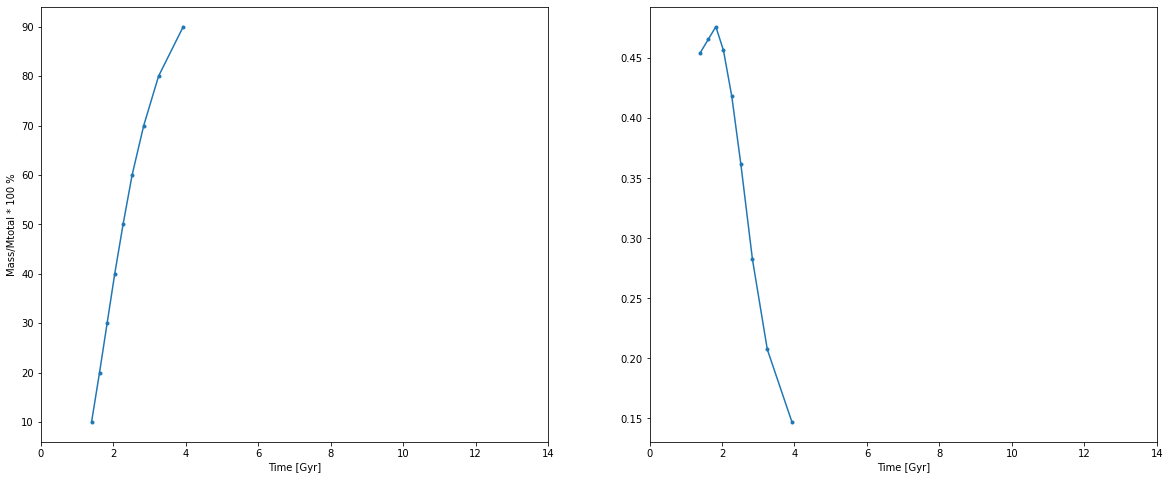

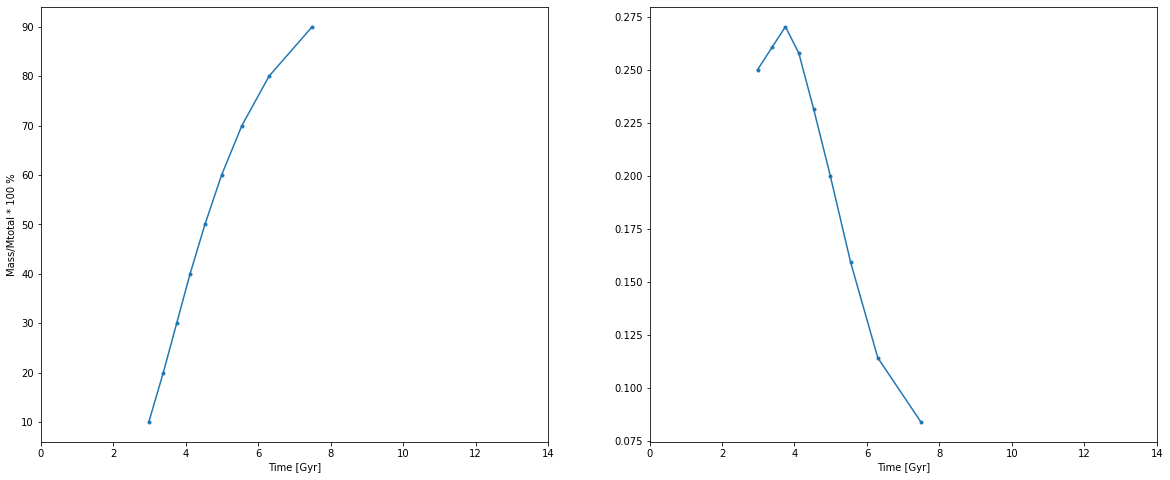

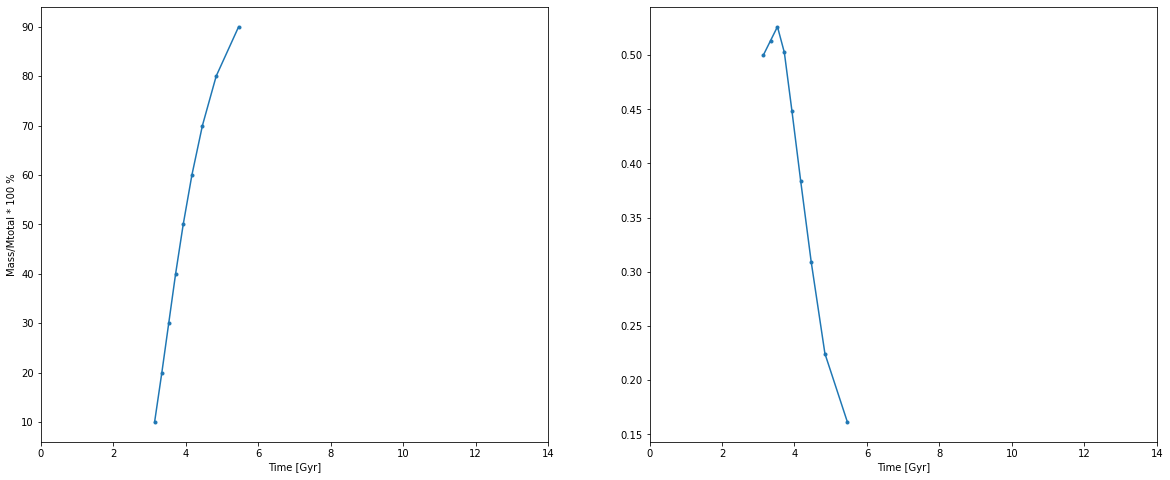

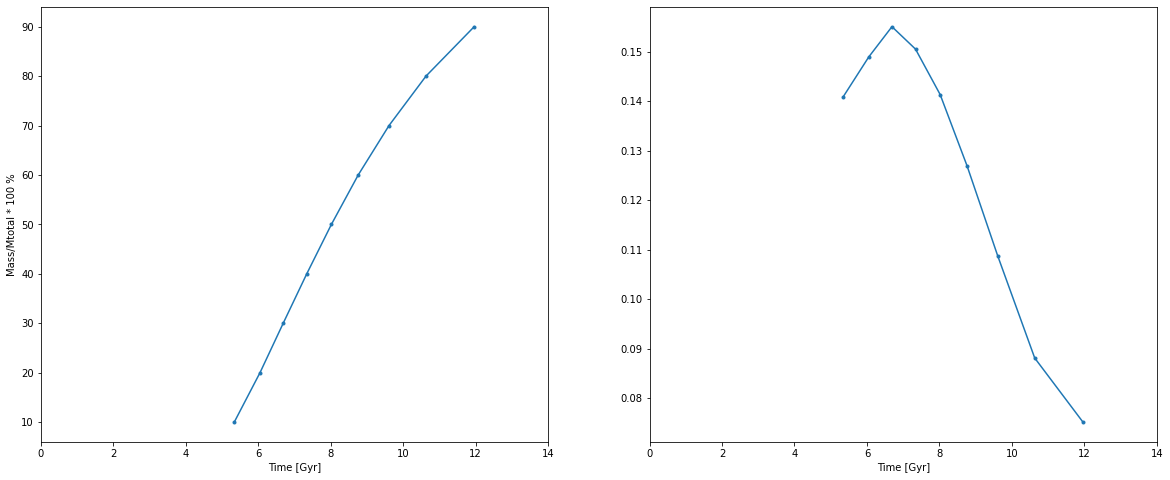

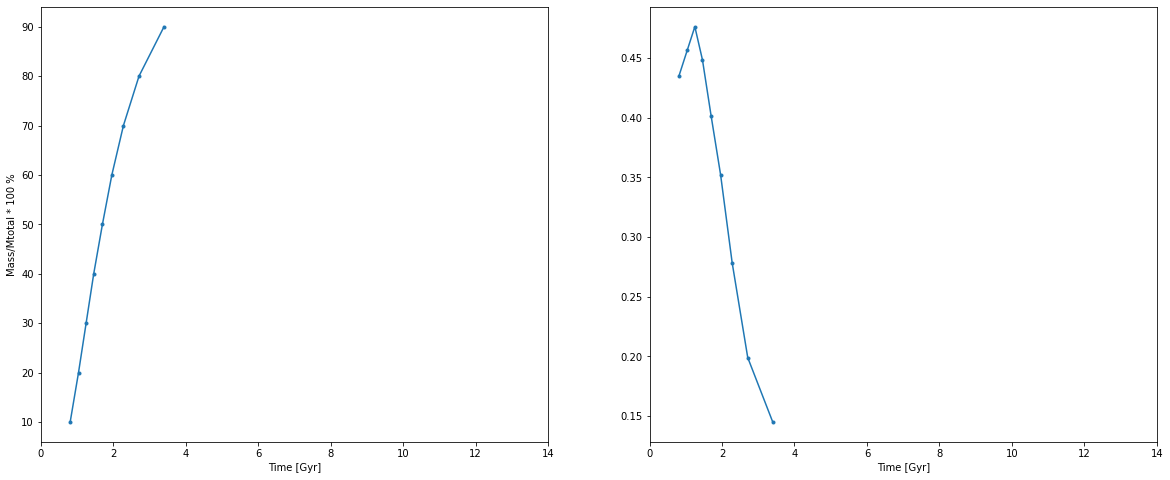

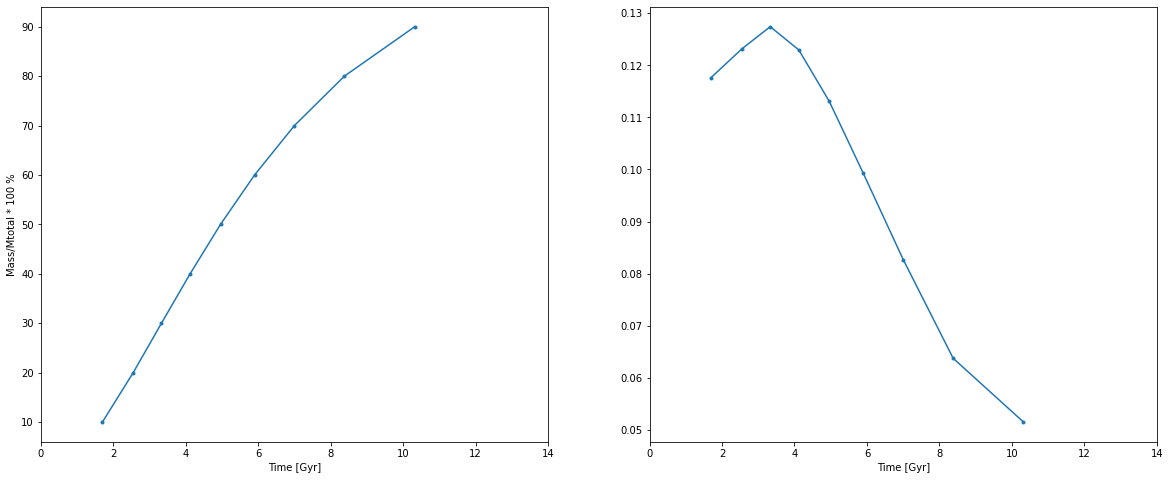

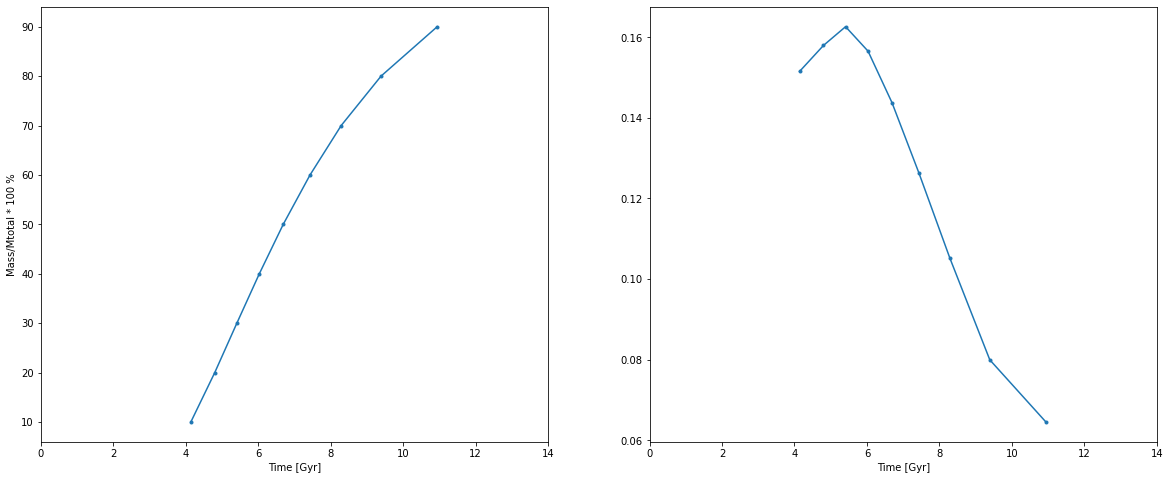

In [20]:
for i in np.random.randint(0,100000,10):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(per[:],np.arange(10,100,10),'.-')
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
    plt.ylabel('Mass/Mtotal * 100 %')
    
    plt.subplot(122)
    plt.plot(t,ms,'.-')
    plt.xlim(0,14)
    plt.xlabel('Time [Gyr]')
    plt.show()



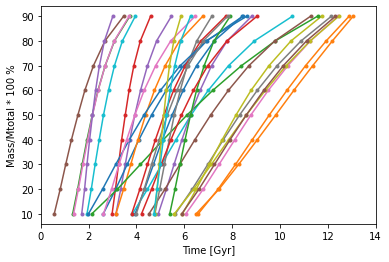

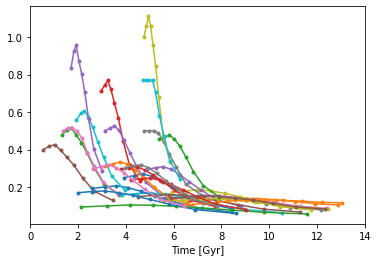

In [25]:
index_list=np.random.randint(0,100000,30)

for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.plot(per[:],np.arange(10,100,10),'.-',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.show()
    
for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.plot(t,ms,'.-',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.show()

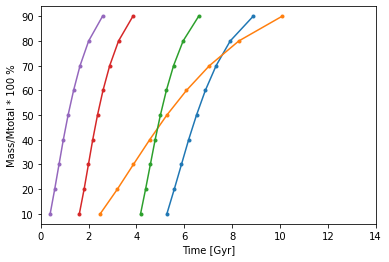

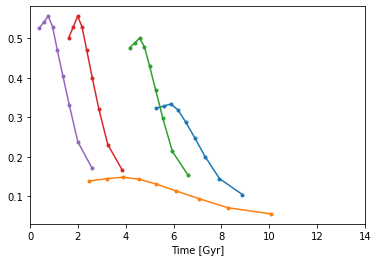

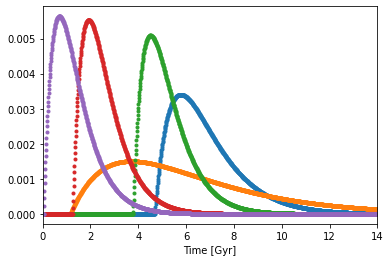

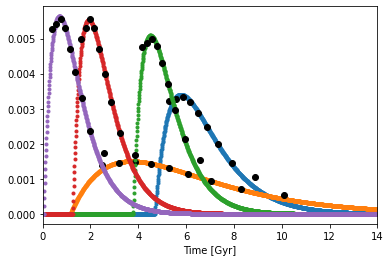

In [10]:
index_list=np.random.randint(0,100000,5)

for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    
    plt.plot(per[:],np.arange(10,100,10),'.-',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.show()
    
for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    plt.plot(t,ms,'.-',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.show()

for k,i in enumerate(index_list):
    plt.plot(np.arange(0,14.01,0.01),ms_real[i,:],'.',color='C'+str(k))
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.show()

for k,i in enumerate(index_list):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)
    plt.plot(np.arange(0,14.01,0.01),ms_real[i,:],'.',color='C'+str(k))
    plt.plot(t,ms/100,'o',color='k')
    
plt.xlim(0,14)
plt.xlabel('Time [Gyr]')
plt.show()

for k,i in enumerate(index_list):
    



In [2]:
from tqdm import tqdm


ts=[]
ms_from_percentiles=[]

for k,i in tqdm(enumerate(np.arange(100000))):
    per=percentiles[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)/100
    ts.append(t)
    ms_from_percentiles.append(ms)
    
    
#from ms_from_percentiles we try to adjust the sfh curve, get points each 0.01 gyrs


100000it [00:08, 11694.00it/s]


In [ ]:
#np.save('ts.npy',ts)
#np.save('ms_from_percentiles.npy',ms_from_percentiles)

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm


def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti,mgal=10**10):
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/i[0]
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr

def generate_weights_from_SFHs(SFR,mgal=10**10,tau=np.linspace(0.3,5,100),ti=np.arange(0,5,0.5),tmin=0,tmax=14,step=0.01,percen=True):
    curves=[]
    t=np.arange(tmin,tmax+step,step) 
    for i in tau:
      for j in ti:
        curve=SFR(t,i,j,mgal)
        curves.append(curve)

    ms=[]
    #non accumulative mass curves, we save it cause we will use it later
    for index,curve in enumerate(curves):        
        sfr_0=curve
        m=[]
        for i,tx in enumerate(t):   
             m_t=sfr_0[i]*step #this gives directly the mass curve (non accumulative)
             m.append(m_t)
        ms.append(m/np.sum(m))

    if percen:
        #compute percentiles
        percentiles=[]
        for i,curve in enumerate(curves):
             mcurve=ms[i]
             m=[]
             percent=[]
             for j in range(len(mcurve)):
                m.append(np.sum(mcurve[:j+1]))
             for k in range(1,10):
                ind=np.argmin(abs(np.array(m)-k/10))
                percent.append(t[ind])
             percentiles.append(percent)  
        return t,ms,percentiles
    else:
        return t,ms

def get_tbins(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))     
    lib_n=np.array(sorted(lib_n))
    return lib_n

def get_data(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))
        
    lib_n=np.array(lib_n)
    data=[]
    
    for j in range(len(lib_n)):
        globals() ['hdul'+str(j)]=fits.open(dir_name+'/'+strs_1+lib[j]+strs_2)
        data.append(np.array(globals()['hdul'+str(j)][0].data))

    hdr=hdul0[0].header
    wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']
    
    ind_sorted=np.argsort(lib_n)
    data=np.array(data,ndmin=2)
    data=data[ind_sorted,:]
    lib_n=lib_n[ind_sorted]
    return wave,data

def interpolate(tbins,t,data):
    data_extended=np.zeros((len(t),len(data[0,:])))
    for i in range(len(data[0,:])): #range 4300
        x=np.interp(t,tbins,data[:,i])
        data_extended[:,i]=x
    return data_extended

def create_spectrum(t,m,wave,data): #only for a galaxy at a time
    spectrum=[]
    for i in range(len(t)):  #we append older first
         spectrum.append(m[i]*data[-i]) #multiply by the weights
    #data is not normalized, we do not normalize the flux
    spectrum=np.array(spectrum)
    sed=np.sum(spectrum,axis=0) #we add the terms of the linear combination
    return wave,sed

def generate_all_spectrums(ts,ms,wave,data,tbins,interpolation_needed=False):
    seds=[]
    for i,m in tqdm(enumerate(ms[:])):
        wave,sed=create_spectrum(ts,m,wave,data)
        seds.append(sed)
    return wave,seds

def plot_sed_sfh(ms,t,wave,seds,n_int):
    for i,sed in enumerate(seds[::n_int]):
        plt.plot(wave,sed,alpha=0.7)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.title('Artificial spectrum')    
    plt.show()
    t_back=t[::-1]
    for i,m in enumerate(ms[::n_int]):
       plt.plot(t_back,m,'-')
    plt.xlim(14,0)
    plt.xlabel('Lookback time [Gyr]')
    plt.title('Mstar norm non acummulative')
    plt.show()

In [38]:
#if we try to fit the spectra only with this, we can't, too litle number of points
#doesnt sum 1, and if we force it the values doesnt match

ts=np.array(ts)
ms_from_percentiles=np.array(ms_from_percentiles)


ts_short=np.copy(ts)
ms_short=np.copy(ms_from_percentiles)

wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
wave,seds_from_percentiles=generate_all_spectrums(ts_short,ms_short,wave,data,tbins,interpolation_needed=True)

KeyboardInterrupt: 

In [7]:
print(np.sum(ms_short*,axis=1))
print(np.sum(ms_real,axis=1))

[7.7634289  7.7176145  7.7176145  7.7176145  7.87447725 7.87447725
 7.88135719 7.86213363 7.86213363 7.86213363 7.82431851 7.82431851
 7.82431851 7.82431851 7.82431851 7.82431851 7.82431851 7.82431851
 7.80345937 7.77839761 7.7634289  7.7176145  7.7176145  7.7176145
 7.87447725 7.87447725 7.86213363 7.86213363 7.86213363 7.86213363
 7.82431851 7.82431851 7.82431851 7.82431851 7.82431851 7.82431851
 7.82431851 7.80345937 7.80345937 7.77839761 7.7634289  7.7176145
 7.7176145  7.7176145  7.87447725 7.87447725 7.86213363 7.86213363
 7.86213363 7.86213363 7.82431851 7.82431851 7.82431851 7.82431851
 7.82431851 7.82431851 7.82431851 7.80345937 7.77839761 7.77839761
 7.7634289  7.7176145  7.7176145  7.7176145  7.87447725 7.87447725
 7.86213363 7.86213363 7.86213363 7.82431851 7.82431851 7.82431851
 7.82431851 7.82431851 7.82431851 7.82431851 7.82431851 7.80345937
 7.77839761 7.77839761 7.7634289  7.7176145  7.7176145  7.87447725
 7.87447725 7.87447725 7.86213363 7.86213363 7.86213363 7.824318

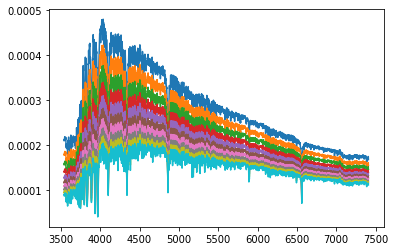

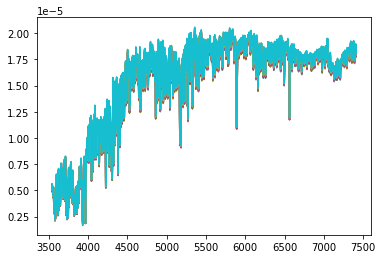

"for i in range(100):\n    plt.plot(wave, seds_from_percentiles[i],label='From percentiles')\n    plt.plot(wave, seds_real[i,:],label='Original')\n    plt.legend()\n    plt.show()"

In [29]:
for i in range(10):
    plt.plot(wave, seds_from_percentiles[i])
plt.show()

for i in np.arange(10):
    plt.plot(wave, seds_real[i])
plt.show()


In [39]:
np.shape(seds_from_percentiles)

(100, 4300)

We try to fit a sfh curve (exponentially delayed) from the points obtainned deriving the percentile curves

In [8]:
#ts=np.array(ts)
#ms_from_percentiles=np.array(ms_from_percentiles)

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm
from scipy.optimize import curve_fit

def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti):
    mgal=1
    step=0.01
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/(i[0]+1e-12)
    #return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) * step #units are Msun

params_list=[]
for i in tqdm(range(1000)):
    params, cov = curve_fit(sfr_linear_exp,ts[i,:],ms_from_percentiles[i,:])
    params_list.append(params)

  0%|▌                                                                                                                                           | 4/1000 [00:00<01:45,  9.45it/s]/tmp/ipykernel_2294/2201144656.py:13: RuntimeWarning: overflow encountered in double_scalars
  i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
/tmp/ipykernel_2294/2201144656.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
 20%|████████████████████████████▏                                                                                                             | 204/1000 [00:21<01:11, 11.10it/s]/tmp/ipykernel_2294/2201144656.py:16: RuntimeWarning: overflow encountered in power
  return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) * step #units are Msun
 28%|█████████████████████████████████

0.31631610943043587 4.728623289097017
0.3246710654915333 3.9861801254197857
0.3222485665536383 3.156389398534267
0.3210199925240741 2.5161570770627444
0.33076715764929254 3.6764419778574333
0.3161331582254688 0.13824016833910135
0.32144337988143196 3.4084838097018997
0.3222474422927085 4.11639488122782
0.3169390819556532 1.5962845657330866
0.3169392894800787 2.056283602316118


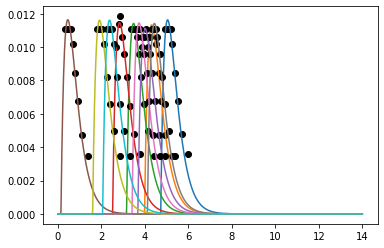

In [11]:
t=np.arange(0,14.01,0.01)


for i in np.random.randint(0,1000,10):
    plt.plot(ts[i,:],ms_from_percentiles[i,:],'o',color='k')
    plt.plot(t,sfr_linear_exp(t,params_list[i][0],params_list[i][1]))
    print(params_list[i][0],params_list[i][1])

In [13]:
t=np.arange(0,14.01,0.01)
sfhs_from_percentiles=[]

for i in tqdm(range(1000)):
    sfhs_from_percentiles.append(sfr_linear_exp(t,params_list[i][0],params_list[i][1]))

In [15]:
print(np.shape(sfhs_from_percentiles))
print(np.sum(sfhs_from_percentiles,axis=1)) #it is perfect, we do not need
#the function generate_weights_from_SFHs

(1000, 1401)
[1.00012261 0.99997108 0.99997101 0.999971   1.00002338 1.00002339
 0.99996457 0.99992274 0.99992295 0.99992329 0.99997651 0.99997648
 0.99997652 0.99997648 0.99997655 0.99997642 0.99997648 0.99997677
 1.00002814 1.0000313  1.00003518 0.99997109 0.99997111 0.99997124
 1.00002336 1.00002339 0.99992284 0.99992325 0.99992258 0.99992302
 0.99997643 0.99997654 0.99997647 0.99997656 0.99997663 0.99999458
 0.99997653 1.00002815 1.00002821 1.0000313  1.00003519 0.99997111
 0.9999711  0.99997106 1.00002352 1.00002348 0.99992301 0.99992269
 0.99992275 0.99992289 0.99997651 0.99997648 0.99997652 0.99997646
 0.99997653 0.99997648 0.99997657 1.00002819 1.00003127 1.00003127
 1.00003528 0.999971   0.99997077 0.9999711  1.00002338 1.00002323
 0.99992211 0.99992273 0.99992282 0.99997644 0.99997649 0.99997648
 0.99997641 0.99997665 0.99997715 0.99997652 0.99997644 1.00002821
 1.00003127 1.00003124 1.00003518 0.99997116 0.99997109 1.00002337
 1.00002342 1.00002336 0.99992286 0.9999228  0.99

In [19]:
wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t,data)
print('Generating spectra...')
wave,seds_from_percentiles=generate_all_spectrums(t,sfhs_from_percentiles,wave,data_extended,tbins)

2it [00:00, 17.26it/s]

Generating spectra...


1000it [01:06, 15.00it/s]


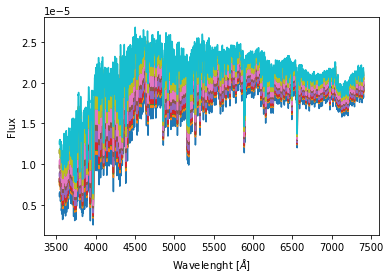

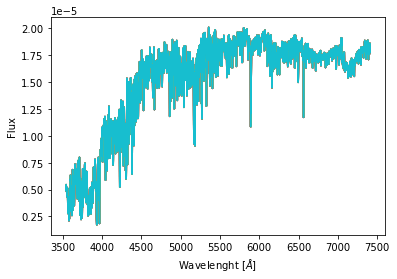

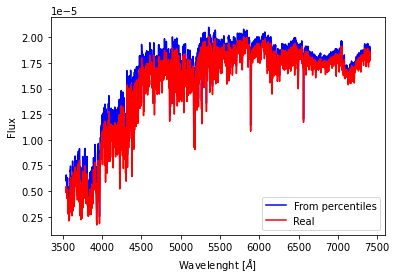

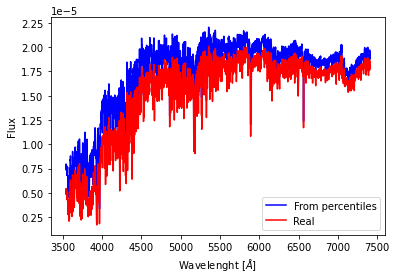

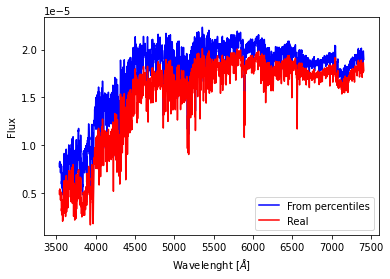

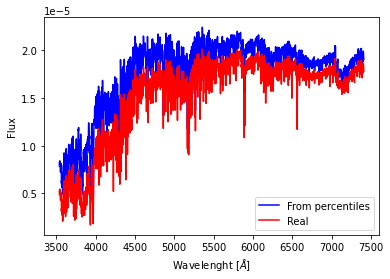

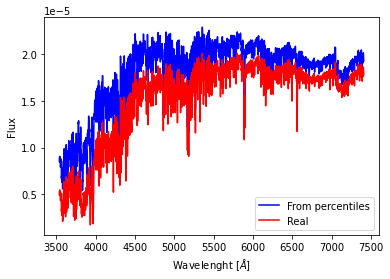

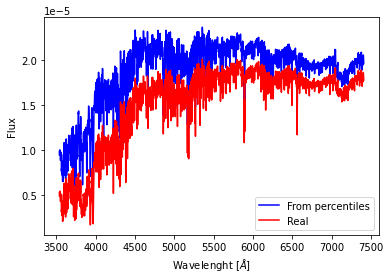

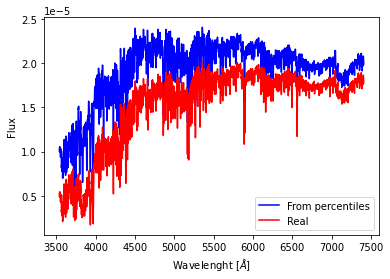

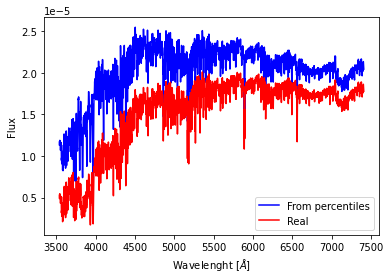

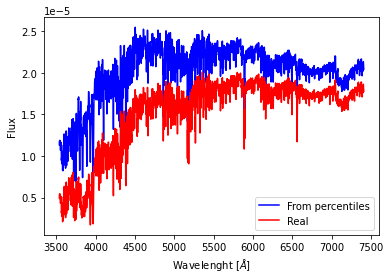

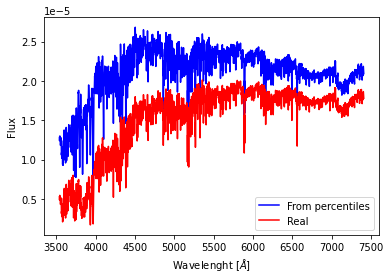

In [23]:
#from percentiles
for i in np.arange(0,1000,100):
    plt.plot(wave, seds_from_percentiles[i])
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')   
plt.show()

#real
for i in np.arange(0,1000,100):
    plt.plot(wave, seds_real[i])
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')   
plt.show()

for i in np.arange(0,1000,100):
    plt.plot(wave, seds_from_percentiles[i],'b',label='From percentiles')
    plt.plot(wave, seds_real[i],'r',label='Real')
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    plt.show()
    

Ok, so right now we are capable to reproduce spectra from percentiles

In [ ]:
#full pipeline for prediction

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm
from scipy.optimize import curve_fit



def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti):
    mgal=1
    step=0.01
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/(i[0]+1e-12)
    #return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) * step #units are Msun

#get sfhs
ts=[]
ms_from_percentiles=[]


for k,i in tqdm(enumerate(range(10000))):
    per=means_sh[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)/100
    ts.append(t)
    ms_from_percentiles.append(ms)
    
ts=np.array(ts)
ms_from_percentiles=np.array(ms_from_percentiles)    


#fit to parametric curves to get more data points
params_list=[]
for i in tqdm(range(10000)):
    params, cov = curve_fit(sfr_linear_exp,ts[i,:],ms_from_percentiles[i,:])
    params_list.append(params)
    
t=np.arange(0,14.01,0.01)
sfhs_from_percentiles=[]
for i in tqdm(range(10000)):
    sfhs_from_percentiles.append(sfr_linear_exp(t,params_list[i][0],params_list[i][1]))

    
#generate spectra
wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t,data)
print('Generating spectra...')
wave,seds_from_percentiles_pred=generate_all_spectrums(t,sfhs_from_percentiles,wave,data_extended,tbins)






In [2]:
#full pipeline for real percentiles

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm
from scipy.optimize import curve_fit



def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti):
    mgal=1
    step=0.01
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/(i[0]+1e-12)
    #return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) * step #units are Msun

#get sfhs
ts=[]
ms_from_percentiles=[]


for k,i in tqdm(enumerate(np.arange(90000,100000))):
    per=percentiles_sh[i,:]
    t=np.copy(per)
    ms=np.gradient(np.arange(0.1,1,0.1),t)/100
    ts.append(t)
    ms_from_percentiles.append(ms)
    
ts=np.array(ts)
ms_from_percentiles=np.array(ms_from_percentiles)    


#fit to parametric curves to get more data points
params_list=[]
for i in tqdm(range(10000)):
    params, cov = curve_fit(sfr_linear_exp,ts[i,:],ms_from_percentiles[i,:])
    params_list.append(params)
    
t=np.arange(0,14.01,0.01)
sfhs_from_percentiles=[]
for i in tqdm(range(10000)):
    sfhs_from_percentiles.append(sfr_linear_exp(t,params_list[i][0],params_list[i][1]))

    
#generate spectra
wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
data_extended=interpolate(tbins,t,data)
print('Generating spectra...')
wave,seds_from_percentiles=generate_all_spectrums(t,sfhs_from_percentiles,wave,data_extended,tbins)


10000it [00:01, 9132.26it/s]
  0%|▏                                                                                                                                       | 17/10000 [00:02<16:38, 10.00it/s]/tmp/ipykernel_4586/885673104.py:20: RuntimeWarning: overflow encountered in double_scalars
  i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
/tmp/ipykernel_4586/885673104.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
  0%|▎                                                                                                                                       | 27/10000 [00:03<14:45, 11.26it/s]/tmp/ipykernel_4586/885673104.py:20: RuntimeWarning: invalid value encountered in multiply
  i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
/tmp/ipy

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

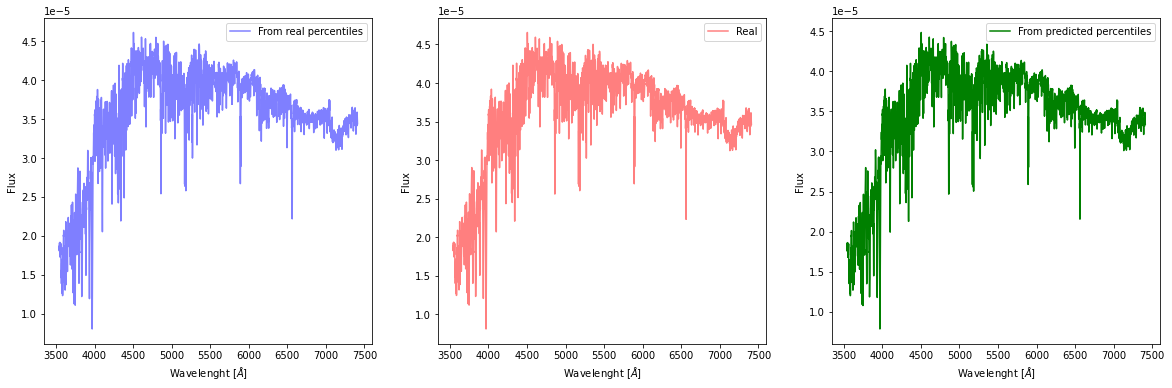

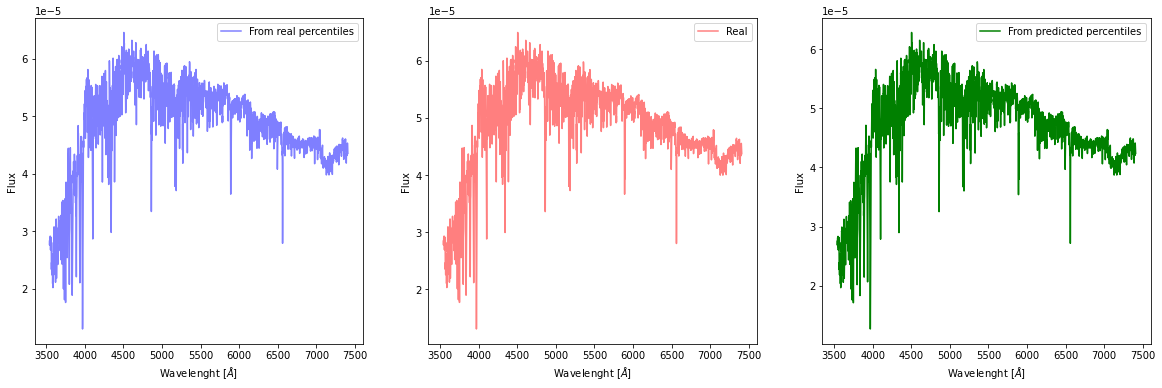

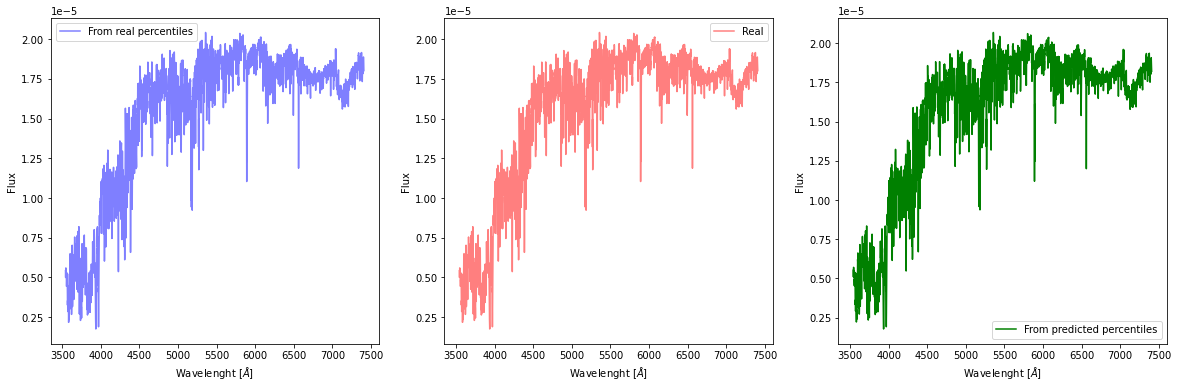

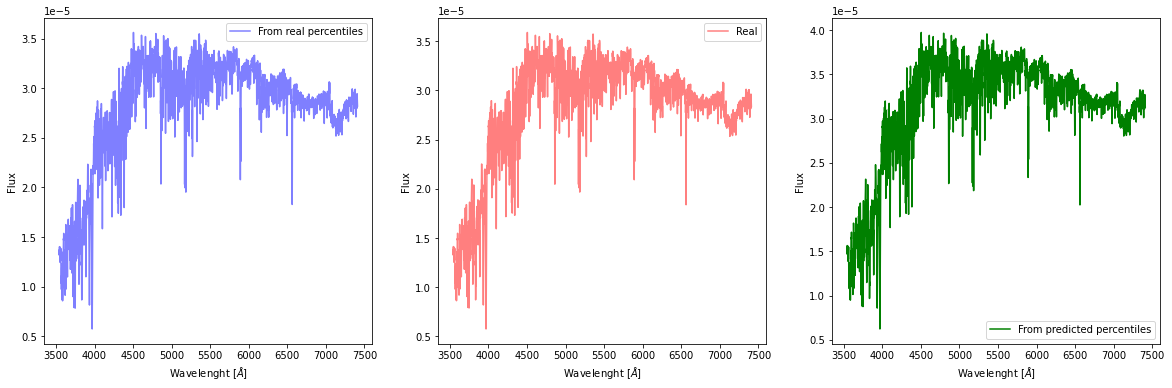

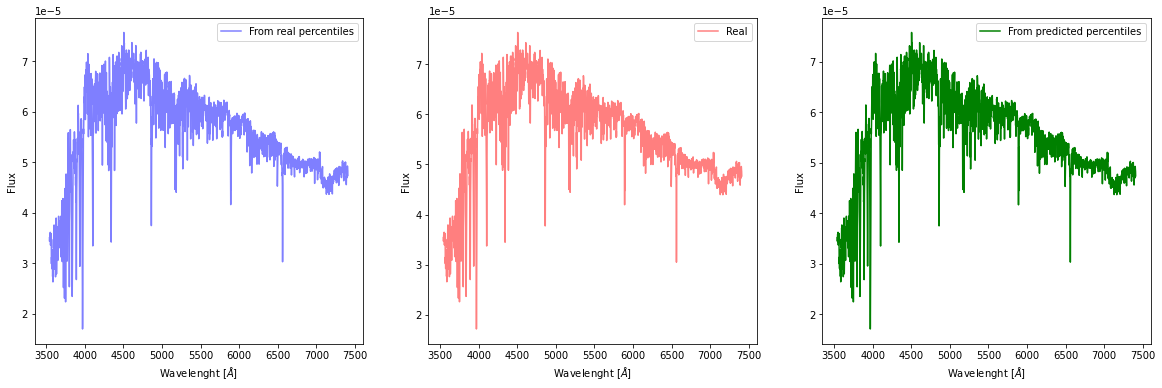

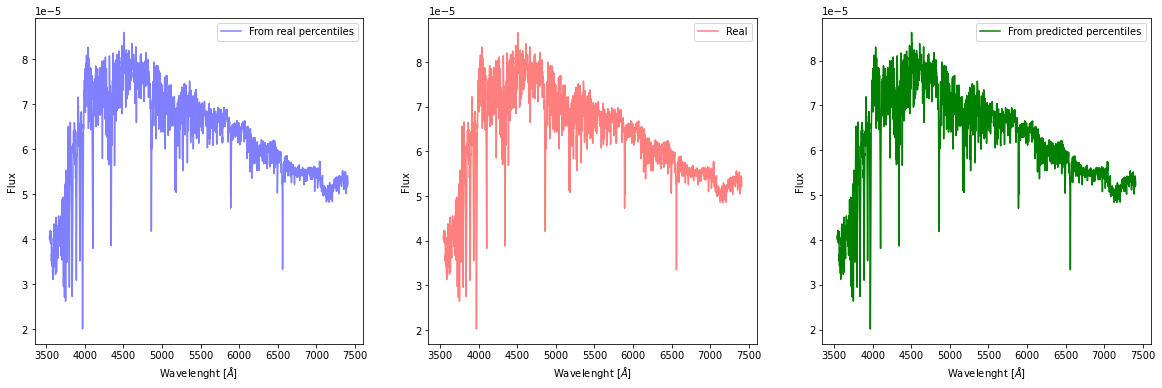

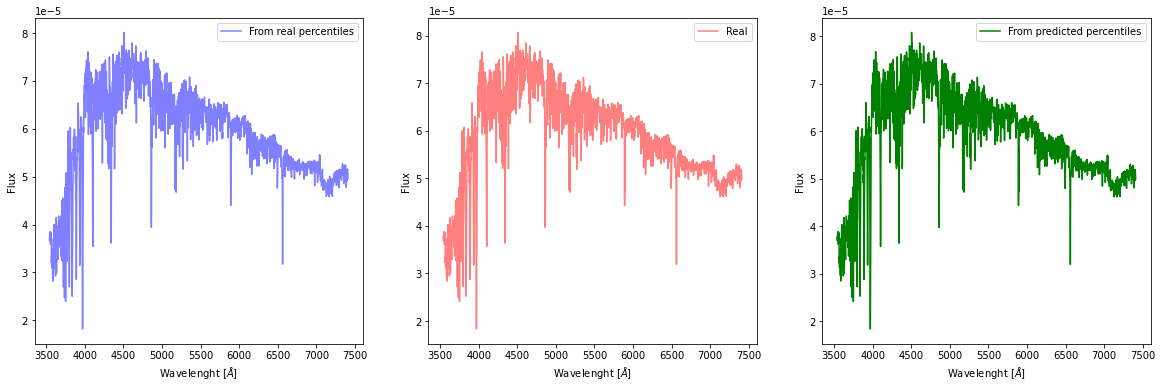

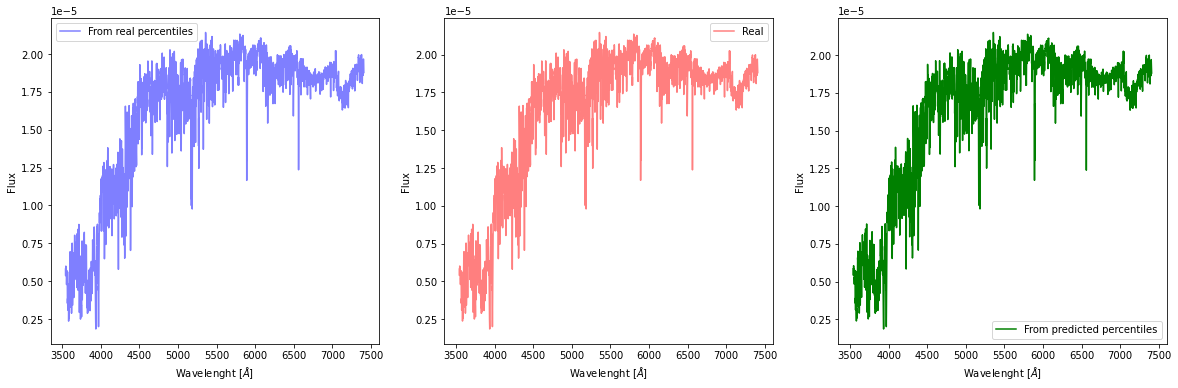

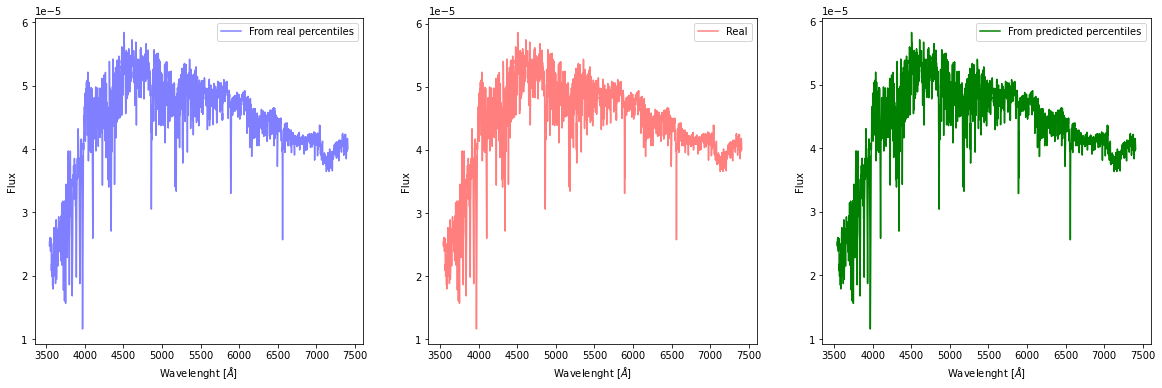

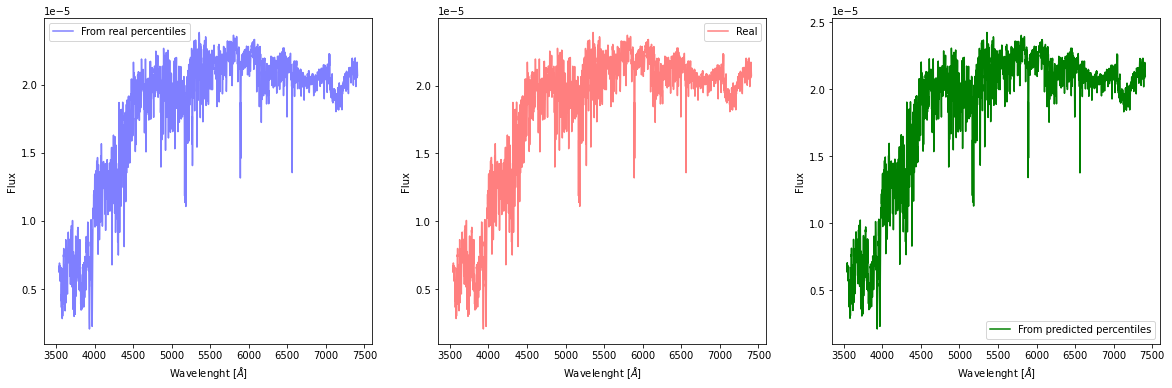

In [13]:
#np.save('./seds_from_percentiles_pred.npy',seds_from_percentiles_pred)
#np.save('./seds_from_percentiles.npy',seds_from_percentiles)

seds_from_percentiles=np.load('../../../seds_from_percentiles.npy')
seds_from_percentiles_pred=np.load('../../../seds_from_percentiles_pred.npy')

#check

seds_real_sh_test=seds_real_sh[90000:] #solo test set

"""#from percentiles real
for i in np.arange(0,10000,10):
    plt.plot(wave, seds_from_percentiles[i])
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')   
plt.show()

#real
for i in np.arange(0,10000,10):
    plt.plot(wave, seds_real_sh_test[i])
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')   
plt.show()

#from percentiles_predicted
for i in np.arange(0,10000,10):
    plt.plot(wave, seds_from_percentiles_pred[i])
plt.xlabel('Wavelenght [$\\AA$]')
plt.ylabel('Flux')   
plt.show()"""

"""for i in np.arange(0,1000,100):
    plt.plot(wave, seds_from_percentiles[i],'b',label='From real percentiles',alpha=0.5)
    plt.plot(wave, seds_real_sh_test[i],'r',label='Real',alpha=0.5)
    plt.plot(wave,seds_from_percentiles_pred[i],'g',label='From predicted percentiles')
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    plt.show()"""
    

for i in np.arange(0,1000,100):
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.plot(wave, seds_from_percentiles[i],'b',label='From real percentiles',alpha=0.5)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    
    plt.subplot(132)
    plt.plot(wave, seds_real_sh_test[i],'r',label='Real',alpha=0.5)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    
    plt.subplot(133)
    plt.plot(wave,seds_from_percentiles_pred[i],'g',label='From predicted percentiles')
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.ylabel('Flux')   
    plt.legend()
    
    plt.show()